In [1]:
import pandas as pd
import numpy as np
from itertools import chain
from operator import sub
import math
import matplotlib.pyplot as plt
import matplotlib.ticker
import scipy.stats as stats
import scipy
%matplotlib inline

In [2]:
df_hits=pd.read_csv("datasets/CECYTEGTO_2017_ANNOTATIONS.csv",sep=",",index_col=False)

In [3]:
df_hits.head()

,id,imageName,fileName,timeStamp,user,status,q1,q2,q3,q4,...,as1,as2,as3,as4,as5,as6,as7,as8,as9,as10
0,1,s_20140117_172513.jpg,4aa87923_c558_4d30_a414_2fc50935db29.php,1509701369,0,COMPLETED,2,1,6,3,...,1,-1,1,-1,1,-1,1,-1,-1,1
1,2,s_20140724_144426.jpg,78527eb6_7e95_4697_88b7_ee0794d18f60.php,1509726096,0,COMPLETED,4,5,1,3,...,-1,-1,-1,-1,-1,-1,1,-1,-1,-1
2,3,s_20140222_142511.jpg,5507a2ae_79aa_4941_8be2_ca884e2dac13.php,1509701505,0,COMPLETED,3,5,4,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,4,s_20140726_114957.jpg,fd7688e5_e0c9_4900_a161_78afad10f5ba.php,1509701546,0,COMPLETED,5,6,1,2,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,5,s_20140121_142101.jpg,80597ee5_84a6_45c2_b9ca_ac0ed6192aef.php,1509701609,0,COMPLETED,6,1,3,4,...,-1,-1,1,1,-1,-1,1,-1,1,1


In [4]:
df_hits.tail()

,id,imageName,fileName,timeStamp,user,status,q1,q2,q3,q4,...,as1,as2,as3,as4,as5,as6,as7,as8,as9,as10
5995,5996,s_20140717_165520.jpg,e72f970c_f198_4551_9bd0_4505baa9b92f.php,1513065743,0,COMPLETED,1,5,6,2,...,-1,1,1,-1,-1,1,1,-1,-1,1
5996,5997,s_20140724_150902.jpg,0dbb7413_cc7a_4f90_82d2_52e63a17673b.php,1513065777,0,COMPLETED,6,1,5,2,...,-1,-1,1,-1,-1,-1,1,1,-1,-1
5997,5998,s_20140712_122902.jpg,ddfba026_5d65_4728_8f42_9e9ec9be8dd7.php,1513065808,0,COMPLETED,6,4,5,3,...,-1,1,-1,-1,1,-1,-1,-1,-1,1
5998,5999,s_20140712_133718.jpg,36004d1c_66b5_46a4_8ef6_171e5f5093a0.php,1513065841,0,COMPLETED,5,2,6,3,...,-1,-1,-1,1,1,-1,1,-1,-1,1
5999,6000,s_20140524_110018.jpg,ce595247_f312_4f53_bb22_199d9dce9978.php,1513065871,0,COMPLETED,5,2,3,4,...,-1,1,1,1,1,-1,-1,1,1,1


In [5]:
#Looking at the missing id's
#https://stackoverflow.com/questions/20718315/how-to-find-a-missing-number-from-a-list/

missing_id=list(chain.from_iterable((df_hits.id[i] + d for d in range(1, diff))
                        for i, diff in enumerate(map(sub, df_hits.id[1:], df_hits.id))
                        if diff > 1))
print("There are "+str(len(missing_id)) +" ids missing:\n")
print(missing_id)

There are 0 ids missing:

[]


In [6]:
#Dropping some columns that are not going to be used
df_hits.drop(["id","fileName","timeStamp","user","status"],axis=1,inplace=True)

In [7]:
#Checking how many pictures are annotated
df_hits["imageName"].groupby(df_hits["imageName"]).size().value_counts()

5    1200
Name: imageName, dtype: int64

In [8]:
df_hits_scenes_count=pd.DataFrame()
df_hits_scenes_count=df_hits[["as1","as2","as3","as4","as5","as6","as7","as8","as9","as10"]].replace({-1:0}).copy()
df_hits_scenes_count["num_scenes"]=df_hits_scenes_count.sum(axis=1)
df_hits_scenes_count=df_hits_scenes_count.groupby("num_scenes").size().reset_index(name='counts')

In [9]:
df_hits_scenes_count["percentage"]=round(df_hits_scenes_count["counts"]/len(df_hits)*100,2)

In [10]:
df_hits_scenes_count

,num_scenes,counts,percentage
0,0,325,5.42
1,1,407,6.78
2,2,499,8.32
3,3,527,8.78
4,4,570,9.50
5,5,696,11.60
6,6,670,11.17
7,7,631,10.52
8,8,547,9.12
9,9,420,7.00


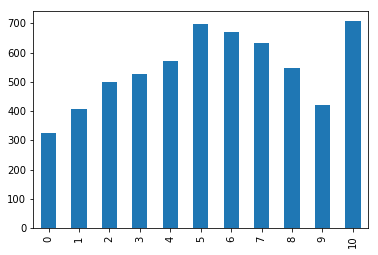

In [11]:
df_hits_scenes_count["counts"].plot(x="num_scenes",y="counts",kind="bar")

In [12]:
scene_answers_columns=[column for column in df_hits.columns.tolist() if column.startswith("as")]
scene_questions_columns=[column for column in df_hits.columns.tolist() if column.startswith("qs")]

In [13]:
scenes_count=[0,0,0,0,0,0,0,0,0,0]
scenes=["VANDALISMO","FALTA DE MANTENIMIENTO","CASAS/EDIFICIOS SUCIOS","BASURA","MALA PLANEACION URBANA",
"FALTA DE ELEMENTOD DE SEGURIDAD","FALTA DE ILUMINACION","VEGETACION DESCUIDADA","CALLES DETERIORADAS",
"ESPACIOS VALDIOS"]

for q_column,q_answer in zip(scene_questions_columns,scene_answers_columns):
    for row in range(len(df_hits)):
        if df_hits[q_answer][row]==1: scenes_count[df_hits[q_column][row]-1]+=1
print("Number of pictures for scene:\n")
for a, b in zip(scenes, scenes_count):
    print(str(a)+": "+str(b))

Number of pictures for scene:

VANDALISMO: 2917
FALTA DE MANTENIMIENTO: 4189
CASAS/EDIFICIOS SUCIOS: 3474
BASURA: 2611
MALA PLANEACION URBANA: 2988
FALTA DE ELEMENTOD DE SEGURIDAD: 4581
FALTA DE ILUMINACION: 3360
VEGETACION DESCUIDADA: 2684
CALLES DETERIORADAS: 3733
ESPACIOS VALDIOS: 1882


## Annotations Quality

In [14]:
#Creating a new dataframe sorted by the name of each image
df_hits_2=df_hits.sort_values("imageName").reset_index(drop=True).copy()

### Getting a new column per label

#### Urban Awareness Labels (q/a)

* label  q1 = Dangerous
* label  q2 = Dirty          
* label  q3 = Pretty          
* label  q4 = Interesting                          
* label  q5 = Polluted        
* label  q6 = Pleasant

In [15]:
df_hits_2["Dangerous"]=np.where(df_hits_2["q1"]==1,df_hits_2["a1"],np.where(df_hits_2["q2"]==1,df_hits_2["a2"],np.where(df_hits_2["q3"]==1,df_hits_2["a3"],np.where(df_hits_2["q4"]==1,df_hits_2["a4"],np.where(df_hits_2["q5"]==1,df_hits_2["a5"],np.where(df_hits_2["q6"]==1,df_hits_2["a6"],np.nan))))))
df_hits_2["Dirty"]=np.where(df_hits_2["q1"]==2,df_hits_2["a1"],np.where(df_hits_2["q2"]==2,df_hits_2["a2"],np.where(df_hits_2["q3"]==2,df_hits_2["a3"],np.where(df_hits_2["q4"]==2,df_hits_2["a4"],np.where(df_hits_2["q5"]==2,df_hits_2["a5"],np.where(df_hits_2["q6"]==2,df_hits_2["a6"],np.nan))))))
df_hits_2["Pretty"]=np.where(df_hits_2["q1"]==3,df_hits_2["a1"],np.where(df_hits_2["q2"]==3,df_hits_2["a2"],np.where(df_hits_2["q3"]==3,df_hits_2["a3"],np.where(df_hits_2["q4"]==3,df_hits_2["a4"],np.where(df_hits_2["q5"]==3,df_hits_2["a5"],np.where(df_hits_2["q6"]==3,df_hits_2["a6"],np.nan))))))
df_hits_2["Interesting"]=np.where(df_hits_2["q1"]==4,df_hits_2["a1"],np.where(df_hits_2["q2"]==4,df_hits_2["a2"],np.where(df_hits_2["q3"]==4,df_hits_2["a3"],np.where(df_hits_2["q4"]==4,df_hits_2["a4"],np.where(df_hits_2["q5"]==4,df_hits_2["a5"],np.where(df_hits_2["q6"]==4,df_hits_2["a6"],np.nan))))))
df_hits_2["Polluted"]=np.where(df_hits_2["q1"]==5,df_hits_2["a1"],np.where(df_hits_2["q2"]==5,df_hits_2["a2"],np.where(df_hits_2["q3"]==5,df_hits_2["a3"],np.where(df_hits_2["q4"]==5,df_hits_2["a4"],np.where(df_hits_2["q5"]==5,df_hits_2["a5"],np.where(df_hits_2["q6"]==5,df_hits_2["a6"],np.nan))))))
df_hits_2["Pleasant"]=np.where(df_hits_2["q1"]==6,df_hits_2["a1"],np.where(df_hits_2["q2"]==6,df_hits_2["a2"],np.where(df_hits_2["q3"]==6,df_hits_2["a3"],np.where(df_hits_2["q4"]==6,df_hits_2["a4"],np.where(df_hits_2["q5"]==6,df_hits_2["a5"],np.where(df_hits_2["q6"]==6,df_hits_2["a6"],np.nan))))))

#### Scene (qs/as)

* descriptor  s1 = VANDALISMO
* descriptor  s2 = FALTA DE MANTENIMIENTO          
* descriptor  s3 = CASAS/EDIFICIOS SUCIOS          
* descriptor  s4 = BASURA                          
* descriptor  s5 = MALA PLANEACION URBANA          
* descriptor  s6 = FALTA DE ELEMENTOD DE SEGURIDAD 
* descriptor  s7 = FALTA DE ILUMINACION            
* descriptor  s8 = VEGETACION DESCUIDADA           
* descriptor  s9 = CALLES DETERIORADAS             
* descriptor s10 = ESPACIOS VALDIOS  

In [16]:
def order_annotations_qs_as(df,descriptor):
    one_list=np.where(df["qs1"]==descriptor,df["as1"],
                            np.where(df["qs2"]==descriptor,df["as2"],
                            np.where(df["qs3"]==descriptor,df["as3"],
                            np.where(df["qs4"]==descriptor,df["as4"],
                            np.where(df["qs5"]==descriptor,df["as5"],
                            np.where(df["qs6"]==descriptor,df["as6"],
                            np.where(df["qs7"]==descriptor,df["as7"],
                            np.where(df["qs8"]==descriptor,df["as8"],
                            np.where(df["qs9"]==descriptor,df["as9"],
                            np.where(df["qs10"]==descriptor,df["as10"],
                            -1))))))))))
    return one_list

In [17]:
df_hits_2["s1"]=order_annotations_qs_as(df_hits_2,1)
df_hits_2["s2"]=order_annotations_qs_as(df_hits_2,2)
df_hits_2["s3"]=order_annotations_qs_as(df_hits_2,3)
df_hits_2["s4"]=order_annotations_qs_as(df_hits_2,4)
df_hits_2["s5"]=order_annotations_qs_as(df_hits_2,5)
df_hits_2["s6"]=order_annotations_qs_as(df_hits_2,6)
df_hits_2["s7"]=order_annotations_qs_as(df_hits_2,7)
df_hits_2["s8"]=order_annotations_qs_as(df_hits_2,8)
df_hits_2["s9"]=order_annotations_qs_as(df_hits_2,9)
df_hits_2["s10"]=order_annotations_qs_as(df_hits_2,10)

#### Labels and columns

In [18]:
labels=["Dangerous","Dirty","Pretty","Interesting","Polluted","Pleasant"]
columns_q=["q"+str(column) for column in range(1,7)]
columns_a=["a"+str(column) for column in range(1,7)]
columns_qs=["qs"+str(column) for column in range(1,11)]
columns_as=["as"+str(column) for column in range(1,11)]

In [19]:
df_hits_ordered=df_hits_2.drop(columns_q+columns_a+columns_qs+columns_as,axis=1).copy()

In [20]:
df_hits_ordered.replace(to_replace={-1:0},inplace=True)

In [21]:
df_hits_ordered.head()

,imageName,Dangerous,Dirty,Pretty,Interesting,Polluted,Pleasant,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10
0,s_20140101_125134.jpg,4.0,4.0,4.0,4.0,4.0,4.0,1,1,0,0,1,0,1,1,0,1
1,s_20140101_125134.jpg,4.0,4.0,4.0,4.0,4.0,4.0,0,0,0,0,0,0,0,0,0,0
2,s_20140101_125134.jpg,4.0,3.0,6.0,6.0,5.0,7.0,0,0,1,0,0,1,0,0,0,0
3,s_20140101_125134.jpg,3.0,2.0,2.0,2.0,2.0,2.0,1,0,0,0,0,0,1,0,0,0
4,s_20140101_125134.jpg,5.0,2.0,2.0,2.0,5.0,2.0,0,1,0,0,1,1,1,1,1,0


### Grouping by image name and getting the individual rates for each label

#### Getting the individual csv files that will be processed in R to get the ICC and Fleiss kappa

In [22]:
def get_DataFrame_label(df,label,image_column,num_raters):
    #Grouping by the images
    df_label=df.groupby(image_column,as_index=True).apply(lambda x: list(x[label])).reset_index()
    df_label.rename(columns={0:"list_rates"},inplace=True)
    #Getting rates
    rates = [df_label, pd.DataFrame(df_label["list_rates"].tolist()).iloc[:, :num_raters]]
    #Getting each rating in a different column
    df_label=pd.concat(rates, axis=1).drop(["list_rates"], axis=1)
    #Renaming the columns
    df_label.rename(columns={i:"rater_"+str(i+1) for i in range(0,num_raters)},inplace=True)
    #df_label.to_csv("datasets/cecyte_annotations/cecyte_gto_hits_"+str(label)+".csv",index=False)
    #print("csv file generated in: "+"datasets/cecyte_annotations/cecyte_gto_hits_"+str(label)+".csv")
    df_label["median"]=df_label.median(axis=1)
    print("\n")
    print("Value counts for median:")
    print("mean: "+str(round(df_label["median"].mean(),2)))
    print("std: "+str(round(df_label["median"].std(),2)))
    
    return df_label

In [23]:
#Label: Dangerous
df_hits_dangerous=get_DataFrame_label(df=df_hits_ordered,label="Dangerous",image_column="imageName",num_raters=5)



Value counts for median:
mean: 3.78
std: 1.45


In [24]:
#Label: Dirty
df_hits_dirty=get_DataFrame_label(df=df_hits_ordered,label="Dirty",image_column="imageName",num_raters=5)



Value counts for median:
mean: 3.53
std: 1.53


In [25]:
#Label: Pretty
df_hits_pretty=get_DataFrame_label(df=df_hits_ordered,label="Pretty",image_column="imageName",num_raters=5)



Value counts for median:
mean: 3.04
std: 1.65


In [26]:
#Label: Interesting:
df_hits_interesting=get_DataFrame_label(df=df_hits_ordered,label="Interesting",image_column="imageName",num_raters=5)



Value counts for median:
mean: 3.0
std: 1.54


In [27]:
#Label: Polluted
df_hits_polluted=get_DataFrame_label(df=df_hits_ordered,label="Polluted",image_column="imageName",num_raters=5)



Value counts for median:
mean: 3.39
std: 1.38


In [28]:
#Label: Pleasant
df_hits_pleasant=get_DataFrame_label(df=df_hits_ordered,label="Pleasant",image_column="imageName",num_raters=5)



Value counts for median:
mean: 3.08
std: 1.58


### Descriptors

In [29]:
def get_DataFrame_descriptor(df,descriptor,image_column,num_raters):
    #Grouping by the images
    df_descriptor=df.groupby(image_column,as_index=True).apply(lambda x: list(x[descriptor])).reset_index()
    df_descriptor.rename(columns={0:"list_rates"},inplace=True)
    #Getting rates
    rates = [df_descriptor, pd.DataFrame(df_descriptor["list_rates"].tolist()).iloc[:, :num_raters]]
    #Getting each rating in a different column
    df_descriptor=pd.concat(rates, axis=1).drop(["list_rates"], axis=1)
    #Renaming the columns
    df_descriptor.rename(columns={i:"rater_"+str(i+1) for i in range(0,num_raters)},inplace=True)
    #df_descriptor.to_csv("datasets/cecyte_annotations/cecyte_gto_hits_"+str(descriptor)+".csv",index=False)
    #print("csv file generated in: "+"datasets/cecyte_annotations/cecyte_gto_hits_"+str(descriptor)+".csv")
    df_descriptor["mean"]=df_descriptor.mean(axis=1)
    df_descriptor["mode"]=df_descriptor.drop("mean",axis=1).mode(axis=1)
    print("\n")
    print("Value counts for mode:")
    print(df_descriptor["mode"].value_counts())
    print("\n")
    print("Value counts for mean:")
    print("mean: "+str(round(df_descriptor["mean"].mean(),2)))
    print("std: "+str(round(df_descriptor["mean"].std(),2)))
    
    return df_descriptor
    

In [30]:
#Descriptor S1: Vandalismo
df_hits_s1=get_DataFrame_descriptor(df=df_hits_ordered,descriptor="s1",image_column="imageName",num_raters=5)



Value counts for mode:
0    653
1    547
Name: mode, dtype: int64


Value counts for mean:
mean: 0.49
std: 0.29


In [31]:
#Descriptor S2: FALTA DE MANTENIMIENTO  
df_hits_s2=get_DataFrame_descriptor(df=df_hits_ordered,descriptor="s2",image_column="imageName",num_raters=5)



Value counts for mode:
1    940
0    260
Name: mode, dtype: int64


Value counts for mean:
mean: 0.7
std: 0.26


In [32]:
#Descriptor S3: CASAS/EDIFICIOS SUCIOS
df_hits_s3=get_DataFrame_descriptor(df=df_hits_ordered,descriptor="s3",image_column="imageName",num_raters=5)



Value counts for mode:
1    744
0    456
Name: mode, dtype: int64


Value counts for mean:
mean: 0.58
std: 0.28


In [33]:
#Descriptor S4: BASURA
df_hits_s4=get_DataFrame_descriptor(df=df_hits_ordered,descriptor="s4",image_column="imageName",num_raters=5)



Value counts for mode:
0    722
1    478
Name: mode, dtype: int64


Value counts for mean:
mean: 0.44
std: 0.27


In [34]:
#Descriptor S5: MALA PLANEACION URBANA
df_hits_s5=get_DataFrame_descriptor(df=df_hits_ordered,descriptor="s5",image_column="imageName",num_raters=5)



Value counts for mode:
0    604
1    596
Name: mode, dtype: int64


Value counts for mean:
mean: 0.5
std: 0.26


In [35]:
#Descriptor S6: FALTA DE ELEMENTOD DE SEGURIDAD
df_hits_s6=get_DataFrame_descriptor(df=df_hits_ordered,descriptor="s6",image_column="imageName",num_raters=5)



Value counts for mode:
1    1059
0     141
Name: mode, dtype: int64


Value counts for mean:
mean: 0.76
std: 0.21


In [36]:
#Descriptor S7: FALTA DE ILUMINACION
df_hits_s7=get_DataFrame_descriptor(df=df_hits_ordered,descriptor="s7",image_column="imageName",num_raters=5)



Value counts for mode:
1    733
0    467
Name: mode, dtype: int64


Value counts for mean:
mean: 0.56
std: 0.25


In [37]:
#Descriptor S8: VEGETACION DESCUIDADA
df_hits_s8=get_DataFrame_descriptor(df=df_hits_ordered,descriptor="s8",image_column="imageName",num_raters=5)



Value counts for mode:
0    691
1    509
Name: mode, dtype: int64


Value counts for mean:
mean: 0.45
std: 0.24


In [38]:
#Descriptor S9: CALLES DETERIORADAS
df_hits_s9=get_DataFrame_descriptor(df=df_hits_ordered,descriptor="s9",image_column="imageName",num_raters=5)



Value counts for mode:
1    814
0    386
Name: mode, dtype: int64


Value counts for mean:
mean: 0.62
std: 0.28


In [39]:
#Descriptor S10: ESPACIOS VALDIOS 
df_hits_s10=get_DataFrame_descriptor(df=df_hits_ordered,descriptor="s10",image_column="imageName",num_raters=5)



Value counts for mode:
0    961
1    239
Name: mode, dtype: int64


Value counts for mean:
mean: 0.31
std: 0.23


## Generating one Consolidated DataFrame

### Urban Awareness labels: median score between raters 

In [40]:
df_cecyte_all_labels=pd.DataFrame()
df_cecyte_all_labels["imageName"]=df_hits_dangerous["imageName"].copy()

#Dangerous
df_cecyte_all_labels=pd.merge(df_cecyte_all_labels,df_hits_dangerous[["imageName","median"]],
                              how="inner",on="imageName").rename(columns={"median":"Dangerous"})
#Dirty
df_cecyte_all_labels=pd.merge(df_cecyte_all_labels,df_hits_dirty[["imageName","median"]],
                              how="inner",on="imageName").rename(columns={"median":"Dirty"})
#Pretty
df_cecyte_all_labels=pd.merge(df_cecyte_all_labels,df_hits_pretty[["imageName","median"]],
                              how="inner",on="imageName").rename(columns={"median":"Pretty"})
#Interesting
df_cecyte_all_labels=pd.merge(df_cecyte_all_labels,df_hits_interesting[["imageName","median"]],
                              how="inner",on="imageName").rename(columns={"median":"Interesting"})
#Polluted
df_cecyte_all_labels=pd.merge(df_cecyte_all_labels,df_hits_polluted[["imageName","median"]],
                              how="inner",on="imageName").rename(columns={"median":"Polluted"})
#Pleasant
df_cecyte_all_labels=pd.merge(df_cecyte_all_labels,df_hits_pleasant[["imageName","median"]],
                              how="inner",on="imageName").rename(columns={"median":"Pleasant"})

In [41]:
df_cecyte_all_labels.head()

,imageName,Dangerous,Dirty,Pretty,Interesting,Polluted,Pleasant
0,s_20140101_125134.jpg,4.0,3.0,4.0,4.0,4.0,4.0
1,s_20140101_125419.jpg,1.0,1.0,5.0,4.0,2.0,4.0
2,s_20140101_125819.jpg,1.0,1.0,7.0,7.0,1.0,6.0
3,s_20140101_125835.jpg,4.0,6.0,7.0,4.0,6.0,7.0
4,s_20140101_125939.jpg,2.0,3.0,2.0,2.0,2.0,4.0


### Descriptors: mode between raters

In [42]:
df_cecyte_all_descriptors=pd.DataFrame()
df_cecyte_all_descriptors["imageName"]=df_hits_s1["imageName"].copy()
#S1
df_cecyte_all_descriptors=pd.merge(df_cecyte_all_descriptors,df_hits_s1[["imageName","mode"]],
                              how="inner",on="imageName").rename(columns={"mode":"s1"})
#S2
df_cecyte_all_descriptors=pd.merge(df_cecyte_all_descriptors,df_hits_s2[["imageName","mode"]],
                              how="inner",on="imageName").rename(columns={"mode":"s2"})
#S3
df_cecyte_all_descriptors=pd.merge(df_cecyte_all_descriptors,df_hits_s3[["imageName","mode"]],
                              how="inner",on="imageName").rename(columns={"mode":"s3"})
#S4
df_cecyte_all_descriptors=pd.merge(df_cecyte_all_descriptors,df_hits_s4[["imageName","mode"]],
                              how="inner",on="imageName").rename(columns={"mode":"s4"})
#S5
df_cecyte_all_descriptors=pd.merge(df_cecyte_all_descriptors,df_hits_s5[["imageName","mode"]],
                              how="inner",on="imageName").rename(columns={"mode":"s5"})
#S6
df_cecyte_all_descriptors=pd.merge(df_cecyte_all_descriptors,df_hits_s6[["imageName","mode"]],
                              how="inner",on="imageName").rename(columns={"mode":"s6"})
#S7
df_cecyte_all_descriptors=pd.merge(df_cecyte_all_descriptors,df_hits_s7[["imageName","mode"]],
                              how="inner",on="imageName").rename(columns={"mode":"s7"})
#S8
df_cecyte_all_descriptors=pd.merge(df_cecyte_all_descriptors,df_hits_s8[["imageName","mode"]],
                              how="inner",on="imageName").rename(columns={"mode":"s8"})
#S9
df_cecyte_all_descriptors=pd.merge(df_cecyte_all_descriptors,df_hits_s9[["imageName","mode"]],
                              how="inner",on="imageName").rename(columns={"mode":"s9"})
#S10
df_cecyte_all_descriptors=pd.merge(df_cecyte_all_descriptors,df_hits_s10[["imageName","mode"]],
                              how="inner",on="imageName").rename(columns={"mode":"s10"})

In [43]:
df_cecyte_all_descriptors_mode=df_cecyte_all_descriptors.copy()

In [44]:
df_cecyte_all_descriptors_mode.head()

,imageName,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10
0,s_20140101_125134.jpg,0,0,0,0,0,0,1,0,0,0
1,s_20140101_125419.jpg,0,1,0,0,0,1,0,0,0,0
2,s_20140101_125819.jpg,0,0,0,0,0,0,0,0,0,0
3,s_20140101_125835.jpg,0,1,1,1,0,1,0,0,1,0
4,s_20140101_125939.jpg,0,0,1,0,0,0,0,0,0,0


In [45]:
df_descriptors_mode=pd.DataFrame()

In [46]:
descr_mode_sum=[]
for i in range(0,10):
    descr_mode_sum.append(df_cecyte_all_descriptors["s"+str(i+1)].sum())
descriptors_=["s"+str(i+1) for i in range(0,10)]

df_descriptors_mode=pd.DataFrame([descriptors_,descr_mode_sum]).transpose().rename(columns={0:"descriptor",1:"frequency"})

In [47]:
def get_int(x):
    x=int(x)
    return x
df_descriptors_mode["frequency"]=df_descriptors_mode.frequency.apply(get_int)

In [48]:
df_descriptors_mode.index=df_descriptors_mode.descriptor

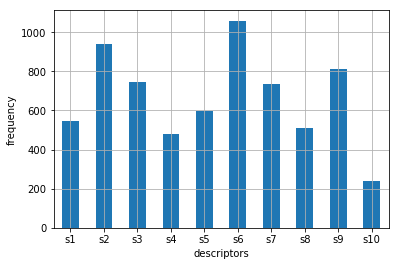

In [49]:
df_descriptors_mode.plot(kind="bar",rot=0,legend=False,grid="on")
plt.ylabel("frequency")
plt.xlabel("descriptors")
plt.savefig('plots/descriptors_distribution_mode.jpg',dpi=900)

### Descriptors: mean between raters

In [50]:
df_cecyte_all_descriptors=pd.DataFrame()
df_cecyte_all_descriptors["imageName"]=df_hits_s1["imageName"].copy()
#S1
df_cecyte_all_descriptors=pd.merge(df_cecyte_all_descriptors,df_hits_s1[["imageName","mean"]],
                              how="inner",on="imageName").rename(columns={"mean":"s1"})
#S2
df_cecyte_all_descriptors=pd.merge(df_cecyte_all_descriptors,df_hits_s2[["imageName","mean"]],
                              how="inner",on="imageName").rename(columns={"mean":"s2"})
#S3
df_cecyte_all_descriptors=pd.merge(df_cecyte_all_descriptors,df_hits_s3[["imageName","mean"]],
                              how="inner",on="imageName").rename(columns={"mean":"s3"})
#S4
df_cecyte_all_descriptors=pd.merge(df_cecyte_all_descriptors,df_hits_s4[["imageName","mean"]],
                              how="inner",on="imageName").rename(columns={"mean":"s4"})
#S5
df_cecyte_all_descriptors=pd.merge(df_cecyte_all_descriptors,df_hits_s5[["imageName","mean"]],
                              how="inner",on="imageName").rename(columns={"mean":"s5"})
#S6
df_cecyte_all_descriptors=pd.merge(df_cecyte_all_descriptors,df_hits_s6[["imageName","mean"]],
                              how="inner",on="imageName").rename(columns={"mean":"s6"})
#S7
df_cecyte_all_descriptors=pd.merge(df_cecyte_all_descriptors,df_hits_s7[["imageName","mean"]],
                              how="inner",on="imageName").rename(columns={"mean":"s7"})
#S8
df_cecyte_all_descriptors=pd.merge(df_cecyte_all_descriptors,df_hits_s8[["imageName","mean"]],
                              how="inner",on="imageName").rename(columns={"mean":"s8"})
#S9
df_cecyte_all_descriptors=pd.merge(df_cecyte_all_descriptors,df_hits_s9[["imageName","mean"]],
                              how="inner",on="imageName").rename(columns={"mean":"s9"})
#S10
df_cecyte_all_descriptors=pd.merge(df_cecyte_all_descriptors,df_hits_s10[["imageName","mean"]],
                              how="inner",on="imageName").rename(columns={"mean":"s10"})

In [51]:
df_cecyte_all_descriptors.head()

,imageName,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10
0,s_20140101_125134.jpg,0.4,0.4,0.2,0.0,0.4,0.4,0.6,0.4,0.2,0.2
1,s_20140101_125419.jpg,0.4,1.0,0.4,0.0,0.0,0.8,0.2,0.0,0.4,0.0
2,s_20140101_125819.jpg,0.2,0.4,0.2,0.0,0.0,0.4,0.0,0.2,0.2,0.0
3,s_20140101_125835.jpg,0.2,0.8,0.6,0.6,0.2,0.8,0.4,0.2,0.6,0.0
4,s_20140101_125939.jpg,0.0,0.4,0.6,0.0,0.4,0.4,0.2,0.4,0.2,0.0


# Correlation - CECYTE data

In [52]:
labels_ordered=['Dangerous', 'Dirty', 'Polluted', 'Interesting', 'Pretty', 'Pleasant']

In [53]:
df_cecyte_labels_corr=df_cecyte_all_labels.copy()
df_cecyte_labels_corr.drop(["imageName"],axis=1,inplace=True)
df_cecyte_labels_corr=df_cecyte_labels_corr[labels_ordered]

In [54]:
df_cecyte_labels_corr.corr(method='spearman')

,Dangerous,Dirty,Polluted,Interesting,Pretty,Pleasant
Dangerous,1.000000,0.538669,0.546328,-0.230955,-0.311456,-0.282525
Dirty,0.538669,1.000000,0.659793,-0.222909,-0.290439,-0.277385
Polluted,0.546328,0.659793,1.000000,-0.197328,-0.260284,-0.235619
Interesting,-0.230955,-0.222909,-0.197328,1.000000,0.807888,0.798012
Pretty,-0.311456,-0.290439,-0.260284,0.807888,1.000000,0.827918
Pleasant,-0.282525,-0.277385,-0.235619,0.798012,0.827918,1.000000


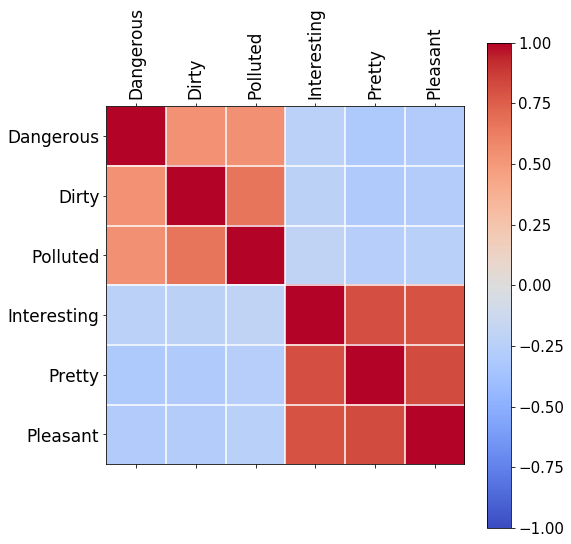

In [55]:
#Plotting the correlation matrix
fig, ax = plt.subplots(figsize=(8, 8))
cax=ax.matshow(df_cecyte_labels_corr.corr(method='spearman'),cmap=plt.get_cmap('coolwarm'), vmin=-1, vmax=1)
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
ax.set_xticklabels([""]+labels_ordered)
ax.set_yticklabels([""]+labels_ordered)
plt.xticks(rotation=90,fontsize=17)
plt.yticks(rotation=0,fontsize=17) 

#Plotting the grid
j=-0.5
for i in range(len(labels_ordered)):
    ax.axhline(j, linestyle='-', color='white')
    ax.axvline(j, linestyle='-', color='white')
    j=j+1

#Marking those labels that are not statistically significant at p<0.05
pvalmat= np.zeros((len(labels_ordered), len(labels_ordered)))
for i in range(len(labels_ordered)):    
    for j in range(len(labels_ordered)):        
        pvalmat[i,j] = scipy.stats.mstats.spearmanr(df_cecyte_labels_corr[df_cecyte_labels_corr.columns[i]], df_cecyte_labels_corr[df_cecyte_labels_corr.columns[j]])[1]
        if pvalmat[i,j]>0.05:
            ax.text(i, j, "X", va='center', ha='center')
cbar=fig.colorbar(cax)
cbar.ax.tick_params(labelsize=15)
fig.tight_layout()
plt.savefig('plots/correlation_locals_6_labels.jpg',figsize=(8, 8),dpi=900)

### Co-ocurrence matrix

In [56]:
df_cecyte_all_labels.head()

,imageName,Dangerous,Dirty,Pretty,Interesting,Polluted,Pleasant
0,s_20140101_125134.jpg,4.0,3.0,4.0,4.0,4.0,4.0
1,s_20140101_125419.jpg,1.0,1.0,5.0,4.0,2.0,4.0
2,s_20140101_125819.jpg,1.0,1.0,7.0,7.0,1.0,6.0
3,s_20140101_125835.jpg,4.0,6.0,7.0,4.0,6.0,7.0
4,s_20140101_125939.jpg,2.0,3.0,2.0,2.0,2.0,4.0


In [57]:
df_cecyte_all_descriptors.head()

,imageName,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10
0,s_20140101_125134.jpg,0.4,0.4,0.2,0.0,0.4,0.4,0.6,0.4,0.2,0.2
1,s_20140101_125419.jpg,0.4,1.0,0.4,0.0,0.0,0.8,0.2,0.0,0.4,0.0
2,s_20140101_125819.jpg,0.2,0.4,0.2,0.0,0.0,0.4,0.0,0.2,0.2,0.0
3,s_20140101_125835.jpg,0.2,0.8,0.6,0.6,0.2,0.8,0.4,0.2,0.6,0.0
4,s_20140101_125939.jpg,0.0,0.4,0.6,0.0,0.4,0.4,0.2,0.4,0.2,0.0


In [58]:
df_merge=df_cecyte_all_labels.merge(df_cecyte_all_descriptors,on="imageName")

In [59]:
descriptor_dict={}
for column_label in labels:
    descriptor_list=[]
    for descriptor in ["s"+str(i+1) for i in range(10)]:
        count_descriptor=0
        for row in range(len(df_merge)):
            if df_merge[column_label][row]>=5.0:
                if df_merge[descriptor][row]>=0.5:
                    count_descriptor+=1
        descriptor_list.append(count_descriptor)
    descriptor_dict[column_label]=descriptor_list
new_index=["s"+str(i+1) for i in range(10)]
df_co_ocurrence=pd.DataFrame.from_dict(descriptor_dict,orient="index")
df_co_ocurrence.rename(columns={i:"s"+str(i+1) for i in range(10)},inplace=True)

In [60]:
df_co_ocurrence.loc[labels_ordered,:].transpose()

,Dangerous,Dirty,Polluted,Interesting,Pretty,Pleasant
s1,212,167,125,34,34,28
s2,297,257,189,89,101,92
s3,260,221,164,54,64,59
s4,185,187,142,33,32,30
s5,226,186,140,41,45,32
s6,301,256,187,130,155,149
s7,236,201,150,71,72,70
s8,169,158,121,42,52,41
s9,281,234,173,69,77,76
s10,98,83,61,20,16,17


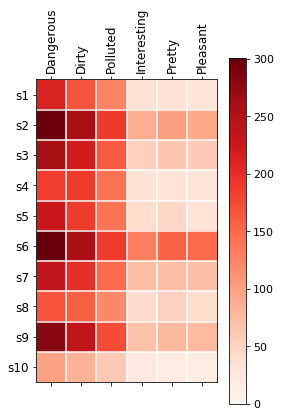

In [61]:
fig, ax = plt.subplots(figsize=(4, 6))
cax=ax.matshow(df_co_ocurrence.loc[labels_ordered,:].transpose(),cmap=plt.get_cmap('Reds'), vmin=0, vmax=max(df_co_ocurrence.max()))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
ax.set_xticklabels([""]+labels_ordered)
ax.set_yticklabels([""]+["s"+str(i+1) for i in range(10)])
plt.xticks(rotation=90,fontsize=12)
plt.yticks(rotation=0,fontsize=12)
#Plotting grid
j=-0.5
for i in range(len(["s"+str(i+1) for i in range(10)])):
    ax.axhline(j, linestyle='-', color='white')
    j=j+1
j=-0.5
for i in range(len(labels_ordered)):
    ax.axvline(j, linestyle='-', color='white')
    j=j+1

cbar=fig.colorbar(cax)
cbar.ax.tick_params(labelsize=11)
fig.tight_layout()
plt.savefig('plots/co_ocurrence_matrix_mode.jpg',dpi=300)

In [62]:
descriptor_dict={}
for column_label in labels:
    descriptor_list=[]
    for descriptor in ["s"+str(i+1) for i in range(10)]:
        count_descriptor=0
        for row in range(len(df_merge)):
            if df_merge[column_label][row]>=5.0:
                if df_merge[descriptor][row]>0.0:
                    count_descriptor+=1
        descriptor_list.append(count_descriptor)
    descriptor_dict[column_label]=descriptor_list
new_index=["s"+str(i+1) for i in range(10)]
df_co_ocurrence_or=pd.DataFrame.from_dict(descriptor_dict,orient="index")
df_co_ocurrence_or.rename(columns={i:"s"+str(i+1) for i in range(10)},inplace=True)
df_co_ocurrence_or.loc[labels_ordered,:].transpose()

,Dangerous,Dirty,Polluted,Interesting,Pretty,Pleasant
s1,314,262,201,141,164,157
s2,319,267,204,172,203,193
s3,319,266,204,151,181,169
s4,303,260,194,142,171,157
s5,316,266,201,149,172,168
s6,320,268,205,187,219,210
s7,318,265,202,165,198,188
s8,316,263,203,149,177,172
s9,319,267,202,163,193,187
s10,279,231,176,135,159,146


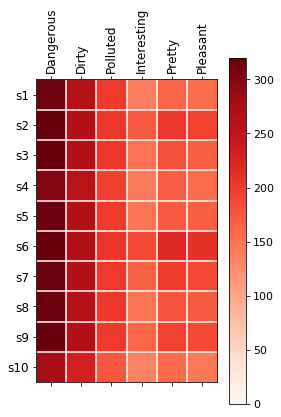

In [63]:
fig, ax = plt.subplots(figsize=(4, 6))
cax=ax.matshow(df_co_ocurrence_or.loc[labels_ordered,:].transpose(),cmap=plt.get_cmap('Reds'), vmin=0, vmax=max(df_co_ocurrence_or.max()))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
ax.set_xticklabels([""]+labels_ordered)
ax.set_yticklabels([""]+["s"+str(i+1) for i in range(10)])
plt.xticks(rotation=90,fontsize=12)
plt.yticks(rotation=0,fontsize=12)
#Plotting the grid
j=-0.5
for i in range(len(["s"+str(i+1) for i in range(10)])):
    ax.axhline(j, linestyle='-', color='white')
    j=j+1
j=-0.5
for i in range(len(labels_ordered)):
    ax.axvline(j, linestyle='-', color='white')
    j=j+1

cbar=fig.colorbar(cax)
cbar.ax.tick_params(labelsize=11)
fig.tight_layout()
plt.savefig('plots/co_occurrence_matrix_or.jpg',dpi=300)

In [64]:
labels_cecyte=labels_ordered+["s"+str(i+1) for i in range(10)]

In [65]:
df_merge_corr=df_merge[["imageName"]+labels_cecyte]

In [66]:
df_merge_corr.corr(method="spearman").loc[["s"+str(i+1) for i in range(10)],labels_ordered]

,Dangerous,Dirty,Polluted,Interesting,Pretty,Pleasant
s1,0.364186,0.318894,0.317685,-0.340272,-0.360131,-0.398689
s2,0.367425,0.383756,0.326905,-0.447141,-0.487332,-0.468229
s3,0.377902,0.384549,0.358934,-0.409801,-0.444691,-0.466876
s4,0.281730,0.430479,0.388722,-0.297190,-0.320515,-0.338188
s5,0.349010,0.330520,0.298793,-0.360114,-0.402715,-0.408065
s6,0.270041,0.224298,0.192769,-0.325038,-0.363676,-0.331031
s7,0.278983,0.238728,0.199004,-0.289293,-0.323381,-0.333143
s8,0.251106,0.304412,0.302391,-0.286526,-0.292588,-0.311364
s9,0.350458,0.372584,0.315555,-0.410157,-0.452841,-0.443794
s10,0.219640,0.197184,0.177712,-0.173745,-0.181585,-0.219465


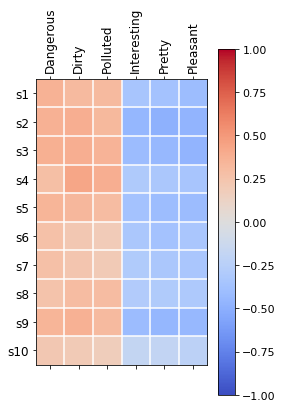

In [67]:
#Plotting the correlation matrix
fig, ax = plt.subplots(figsize=(4, 6))
cax=ax.matshow(df_merge_corr.drop("imageName",axis=1).corr(method='spearman').loc[["s"+str(i+1) for i in range(10)],labels_ordered],cmap=plt.get_cmap('coolwarm'), vmin=-1, vmax=1)
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
ax.set_xticklabels([""]+labels_ordered)
ax.set_yticklabels([""]+["s"+str(i+1) for i in range(10)])
plt.xticks(rotation=90,fontsize=12)
plt.yticks(rotation=0,fontsize=12) 

#Plotting the grid
j=-0.5
for i in range(len(labels_ordered)):
    ax.axvline(j, linestyle='-', color='white')
    j=j+1
j=-0.5
for i in range(len(["s"+str(i+1) for i in range(10)])):
    ax.axhline(j, linestyle='-', color='white')
    j=j+1
    
    
#Marking those labels that are not statistically significant at p<0.05
#From previous execution of this section, we got that all the values are statistically significant at p<0.05
#pvalmat= np.zeros((len(labels_cecyte), len(labels_cecyte)))
#for i in range(len(labels_ordered)):    
    #for j in range(len(labels_ordered)):        
        #pvalmat[i,j] = scipy.stats.mstats.spearmanr(df_merge_corr.drop("imageName",axis=1)[df_merge_corr.drop("imageName",axis=1).columns[i]], df_merge_corr.drop("imageName",axis=1)[df_merge_corr.drop("imageName",axis=1).columns[j]])[1]
        #if pvalmat[i,j]>0.05:
            #ax.text(i, j, "X", va='center', ha='center')
cbar=fig.colorbar(cax)
cbar.ax.tick_params(labelsize=11)
fig.tight_layout()
plt.savefig('plots/correlation_locals_descriptors_labels.jpg',dpi=300)

## Plotting ratings for both MTurk and CECYTE datasets

In [167]:
df_mturk_6_labels=pd.read_csv("datasets/all-places-all-labels-median-medina.csv",sep=",")[["annotation"]+labels].rename(columns={"annotation":"imageName"})

In [69]:
df_mturk_6_labels.head()

,imageName,Dangerous,Dirty,Pretty,Interesting,Polluted,Pleasant
0,s_20140101_125134.jpg,2.0,2.0,5.0,5.5,2.0,5.0
1,s_20140101_125419.jpg,2.5,3.0,3.0,5.0,2.5,4.0
2,s_20140101_125819.jpg,2.0,2.5,5.0,6.0,2.0,6.0
3,s_20140101_125835.jpg,4.0,4.0,3.0,4.5,3.0,4.0
4,s_20140101_125939.jpg,3.0,3.0,5.0,5.5,2.5,5.5


In [70]:
df_cecyte_all_labels.head()

,imageName,Dangerous,Dirty,Pretty,Interesting,Polluted,Pleasant
0,s_20140101_125134.jpg,4.0,3.0,4.0,4.0,4.0,4.0
1,s_20140101_125419.jpg,1.0,1.0,5.0,4.0,2.0,4.0
2,s_20140101_125819.jpg,1.0,1.0,7.0,7.0,1.0,6.0
3,s_20140101_125835.jpg,4.0,6.0,7.0,4.0,6.0,7.0
4,s_20140101_125939.jpg,2.0,3.0,2.0,2.0,2.0,4.0


In [155]:
def roundup(x):
    return round(x+0.001)

In [71]:
def plot_distributions(df_locals,df_mturk,label,image_column):
    df_temp=pd.merge(df_mturk[[image_column,label]],df_locals[[image_column,label]],on=image_column).drop(image_column,axis=1).apply(roundup)
    mturk_label=label+"_x"
    locals_label=label+"_y"
    mturk=df_temp.groupby([mturk_label],as_index=False).count().rename(columns={mturk_label:"score",locals_label:"MTurkers"})
    locals_=df_temp.groupby([locals_label],as_index=False).count().rename(columns={locals_label:"score",mturk_label:"CECYTE"})
    df_return=pd.merge(mturk,locals_,on="score",how="outer")
    df_return["score"]=df_return["score"].replace(to_replace={1.0:"(0,1]",2.0:"(1,2]",3.0:"(2,3]",4.0:"(3,4]",5.0:"(4,5]",6.0:"(5,6]",7:"(6,7]"})
    df_return.plot("score",kind="bar",grid=True,rot=0,figsize=(7,5),fontsize=13,width=0.8)
    plt.xlabel('Rating score',fontsize=13)
    plt.ylabel('frequency',fontsize=13)
    plt.savefig('plots/distributions_mturk_cecyte/'+str(label)+".jpg", dpi=300)

In [156]:
def get_percentage_between_groups(label,df_locals,df_mturk,image_column):
    df_temp=pd.merge(df_mturk[[image_column,label]],df_locals[[image_column,label]],on=image_column).drop(image_column,axis=1).apply(roundup)
    mturk_label=label+"_x"
    locals_label=label+"_y"
    mturk=df_temp.groupby([mturk_label],as_index=False).count().rename(columns={mturk_label:"score",locals_label:"MTurkers"})
    locals_=df_temp.groupby([locals_label],as_index=False).count().rename(columns={locals_label:"score",mturk_label:"CECYTE"})
    df_return=pd.merge(mturk,locals_,on="score",how="outer")
    temp=df_return[df_return["score"].isin([5,6,7])][["MTurkers","CECYTE"]].sum()

    round(temp/temp.sum()*100,2)

MTurkers    58.22
CECYTE      41.78
dtype: float64

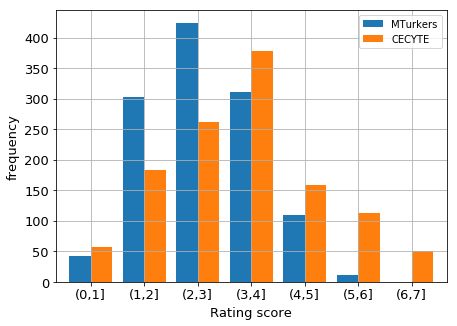

In [72]:
#Dangerous
df_prueba=plot_distributions(df_cecyte_all_labels,df_mturk_6_labels,"Dangerous","imageName")

In [158]:
get_percentage_between_groups("Dangerous",df_cecyte_all_labels,df_mturk_6_labels,"imageName")

MTurkers    27.44
CECYTE      72.56
dtype: float64

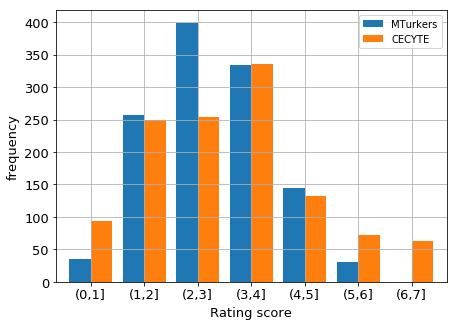

In [73]:
#Dirty
df_prueba=plot_distributions(df_cecyte_all_labels,df_mturk_6_labels,"Dirty","imageName")

In [159]:
get_percentage_between_groups("Dirty",df_cecyte_all_labels,df_mturk_6_labels,"imageName")

MTurkers    39.5
CECYTE      60.5
dtype: float64

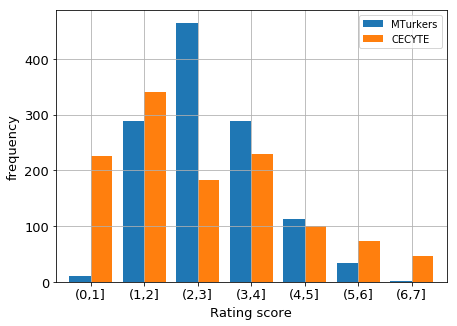

In [74]:
#Pretty
df_prueba=plot_distributions(df_cecyte_all_labels,df_mturk_6_labels,"Pretty","imageName")

In [160]:
get_percentage_between_groups("Pretty",df_cecyte_all_labels,df_mturk_6_labels,"imageName")

MTurkers    40.05
CECYTE      59.95
dtype: float64

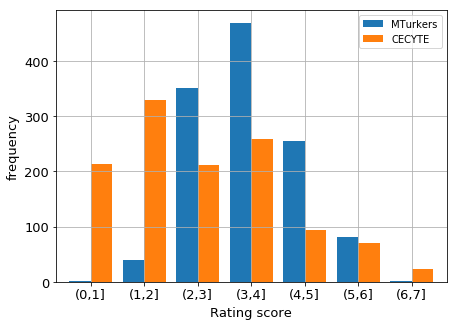

In [75]:
#Interesting
df_prueba=plot_distributions(df_cecyte_all_labels,df_mturk_6_labels,"Interesting","imageName")

In [161]:
get_percentage_between_groups("Interesting",df_cecyte_all_labels,df_mturk_6_labels,"imageName")

MTurkers    64.39
CECYTE      35.61
dtype: float64

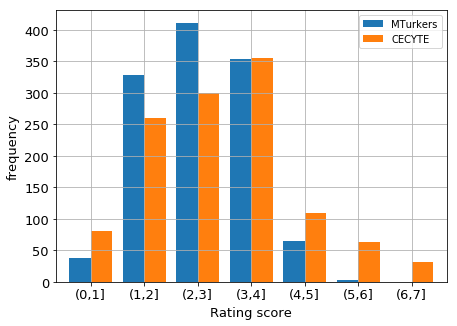

In [76]:
#Polluted
df_prueba=plot_distributions(df_cecyte_all_labels,df_mturk_6_labels,"Polluted","imageName")

In [162]:
get_percentage_between_groups("Polluted",df_cecyte_all_labels,df_mturk_6_labels,"imageName")

MTurkers    24.91
CECYTE      75.09
dtype: float64

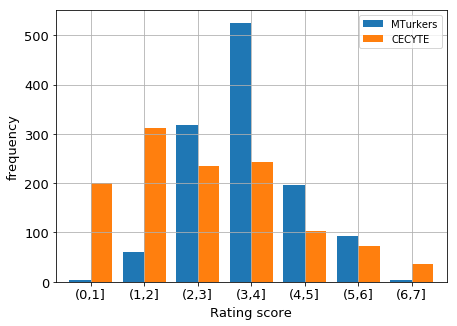

In [77]:
#Pleasant
df_prueba=plot_distributions(df_cecyte_all_labels,df_mturk_6_labels,"Pleasant","imageName")

In [163]:
get_percentage_between_groups("Pleasant",df_cecyte_all_labels,df_mturk_6_labels,"imageName")

MTurkers    58.22
CECYTE      41.78
dtype: float64

In [175]:
#Getting the image I-1, as shown in the scatter plot of the pair-wise analysis
#of the ratings made by the both groups for the label Dangerous.
df_cecyte_all_labels[df_cecyte_all_labels["Dangerous"]==7].merge(df_mturk_6_labels[df_mturk_6_labels["Dangerous"]==1.5],on="imageName").rename(columns={"Dangerous_x":"Dangerous_CECYTE","Dangerous_y":"Dangerous_MTurk"})[["imageName","Dangerous_CECYTE","Dangerous_MTurk"]]

,imageName,Dangerous_CECYTE,Dangerous_MTurk
0,s_20140510_142207.jpg,7.0,1.5


In [179]:
#Getting the image I-2, as shown in the scatter plot of the pair-wise analysis
#of the ratings made by the both groups for the label Interesting.
df_cecyte_all_labels[df_cecyte_all_labels["Interesting"]==1].merge(df_mturk_6_labels[df_mturk_6_labels["Interesting"]==6],on="imageName").rename(columns={"Interesting_x":"Interesting_CECYTE","Interesting_y":"Interesting_MTurk"})[["imageName","Interesting_CECYTE","Interesting_MTurk"]]

,imageName,Interesting_CECYTE,Interesting_MTurk
0,s_20140117_173343.jpg,1.0,6.0
